# Colorization
수업에서 모델 생성방법은 제외

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd gdrive/MyDrive/AIED_CON

/content/gdrive/MyDrive/AIED_CON


In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from skimage import color
import numpy as np
import os 
from tqdm import tqdm

class ColorizationDataset(Dataset):
  def __init__(self):
    self.path1 = "unlabeleddata/trainData"
    self.image_list = []
    self.get_image_list()
    self.item_list = []
    self.image_to_tensor()

  def get_image_list(self):
    for a in os.listdir(self.path1):
      self.image_list.append(self.path1+"/"+a)

  def __len__(self):
    return len(self.image_list)

  def image_to_tensor(self):
    for path in tqdm(self.image_list):
      image = Image.open(path)
      image = np.asarray(image.resize((256,256)).convert("RGB"))
      image_lab = color.rgb2lab(image)
      input = image_lab[:,:,0]
      target = image_lab[:,:,1:]
      input = np.expand_dims(input, axis=-1)
      input = input.transpose((2,0,1))
      target = target.transpose((2,0,1))
      self.item_list.append((torch.tensor(input, dtype = torch.float32), torch.tensor(target, dtype = torch.float32)))
  
  def __getitem__(self, idx):
    return dict(input = self.item_list[idx][0], target = self.item_list[idx][1])
    
Data = ColorizationDataset()

100%|██████████| 7671/7671 [05:02<00:00, 25.33it/s]


In [5]:
import torch
import torch.nn as nn

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [6]:
class transfermodel(BaseColor):
  def __init__(self):
    super(transfermodel, self).__init__()
    model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[nn.BatchNorm2d(64),]
    model1+=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
    model1+=[nn.ReLU(True),]
    model1+=[nn.BatchNorm2d(128),]
    self.model = nn.Sequential(*model1)

  def forward(self, input_l):
    return self.model(self.normalize_l(input_l))


In [7]:
class Colorization(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(Colorization, self).__init__()
        self.model = transfermodel()
        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1 = self.model(input_l)
        out_reg = self.model_out(self.softmax(conv1))
        return self.unnormalize_ab(self.upsample4(out_reg))

In [8]:
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

In [9]:
from torch.optim import Adam

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = ECCVGenerator()
optimizer = Adam(model.parameters(),lr = 1e-4)
loss_fn = nn.MSELoss().to(device)

In [10]:
from torch.utils.data import DataLoader, random_split

train_dl = DataLoader(Data, batch_size = 64, shuffle = True)

In [11]:
from tqdm import tqdm
import numpy as np

model.to(device)
model.train()
for ep in range(100):
  model.train()
  ep_loss = []
  ep_acc = []
  for batch in tqdm(train_dl):
    input = batch["input"].to(device)
    target = batch["target"].to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, torch.tensor(target,dtype = torch.float32))
    loss.backward()
    optimizer.step()
    ep_loss.append(loss.item())
  print(f"{ep+1}-epoch, loss : {np.mean(ep_loss):.3f}")

  0%|          | 0/120 [00:00<?, ?it/s]<ipython-input-11-3d369722b88b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(output, torch.tensor(target,dtype = torch.float32))
100%|██████████| 120/120 [00:38<00:00,  3.15it/s]


1-epoch, loss : 242.304


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


2-epoch, loss : 234.726


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


3-epoch, loss : 232.804


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


4-epoch, loss : 231.606


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


5-epoch, loss : 227.941


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


6-epoch, loss : 224.608


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


7-epoch, loss : 221.647


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


8-epoch, loss : 219.434


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


9-epoch, loss : 219.495


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


10-epoch, loss : 218.075


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


11-epoch, loss : 215.020


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


12-epoch, loss : 214.409


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


13-epoch, loss : 212.532


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


14-epoch, loss : 209.891


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


15-epoch, loss : 210.060


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


16-epoch, loss : 210.268


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


17-epoch, loss : 207.502


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


18-epoch, loss : 205.420


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


19-epoch, loss : 206.616


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


20-epoch, loss : 205.713


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


21-epoch, loss : 202.654


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


22-epoch, loss : 199.935


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


23-epoch, loss : 196.749


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


24-epoch, loss : 193.693


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


25-epoch, loss : 193.058


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


26-epoch, loss : 190.270


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


27-epoch, loss : 189.439


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


28-epoch, loss : 185.930


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


29-epoch, loss : 183.451


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


30-epoch, loss : 180.487


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


31-epoch, loss : 176.435


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


32-epoch, loss : 171.943


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


33-epoch, loss : 170.722


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


34-epoch, loss : 167.148


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


35-epoch, loss : 162.262


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


36-epoch, loss : 158.651


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


37-epoch, loss : 155.621


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


38-epoch, loss : 150.900


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


39-epoch, loss : 147.803


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


40-epoch, loss : 141.399


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


41-epoch, loss : 136.092


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


42-epoch, loss : 132.601


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


43-epoch, loss : 127.865


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


44-epoch, loss : 123.352


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


45-epoch, loss : 119.672


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


46-epoch, loss : 113.950


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


47-epoch, loss : 109.781


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


48-epoch, loss : 106.103


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


49-epoch, loss : 102.245


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


50-epoch, loss : 97.170


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


51-epoch, loss : 93.351


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


52-epoch, loss : 89.436


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


53-epoch, loss : 86.216


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


54-epoch, loss : 83.284


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


55-epoch, loss : 79.844


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


56-epoch, loss : 77.462


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


57-epoch, loss : 74.872


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


58-epoch, loss : 73.059


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


59-epoch, loss : 70.535


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


60-epoch, loss : 68.361


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


61-epoch, loss : 65.754


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


62-epoch, loss : 63.650


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


63-epoch, loss : 62.628


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


64-epoch, loss : 60.029


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


65-epoch, loss : 58.195


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


66-epoch, loss : 57.891


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


67-epoch, loss : 56.019


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


68-epoch, loss : 54.608


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


69-epoch, loss : 52.988


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


70-epoch, loss : 52.269


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


71-epoch, loss : 50.669


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


72-epoch, loss : 48.517


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


73-epoch, loss : 49.082


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


74-epoch, loss : 47.562


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


75-epoch, loss : 47.502


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


76-epoch, loss : 46.764


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


77-epoch, loss : 44.744


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


78-epoch, loss : 44.638


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


79-epoch, loss : 44.582


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


80-epoch, loss : 43.410


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


81-epoch, loss : 42.403


100%|██████████| 120/120 [00:29<00:00,  4.04it/s]


82-epoch, loss : 41.404


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


83-epoch, loss : 40.444


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


84-epoch, loss : 40.331


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


85-epoch, loss : 39.770


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


86-epoch, loss : 38.890


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


87-epoch, loss : 37.847


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


88-epoch, loss : 37.983


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


89-epoch, loss : 37.222


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


90-epoch, loss : 37.023


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


91-epoch, loss : 36.274


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


92-epoch, loss : 35.514


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


93-epoch, loss : 35.174


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


94-epoch, loss : 38.687


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


95-epoch, loss : 37.038


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


96-epoch, loss : 34.462


100%|██████████| 120/120 [00:29<00:00,  4.02it/s]


97-epoch, loss : 33.259


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


98-epoch, loss : 40.094


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]


99-epoch, loss : 60.804


100%|██████████| 120/120 [00:29<00:00,  4.03it/s]

100-epoch, loss : 40.103


In [13]:
model.cpu()
torch.save(model.state_dict(), "save/colorization.pt")

In [ ]:
import matplotlib.pyplot as plt
import random
#색칠하기기
def compare_images(n, data):
  img_list = random.sample(range(len(data)),n)
  path_list = []
  count = 1
  for i in img_list:
    path = data.image_list[i]
    path_list.append(path)
    image = Image.open(path)
    color_image = np.asarray(image.resize((256,256)).convert("RGB"))
    plt.figure(figsize = (15, 15))
    plt.subplot(n,3, count)
    plt.imshow(color_image)
    plt.axis('off')

    gray_image = np.asarray(image.resize((256,256)).convert("L"))
    plt.subplot(n,3,count+1)
    plt.imshow(gray_image, cmap="gray")
    plt.axis('off') 
    
    image_lab = color.rgb2lab(color_image)
    input = image_lab[:,:,0]
    input = np.expand_dims(input, axis=-1)
    input = input.transpose((2,0,1))
    input = torch.tensor(input, dtype = torch.float32).unsqueeze(dim = 0).to(device)
    output = model(input)
    input = input.detach().cpu()
    output = output.detach().cpu()
    out_img = torch.cat((input,output),dim=1).squeeze().numpy()
    output = out_img.transpose((1,2,0))
    image_rgb = color.lab2rgb(output)
    plt.subplot(n,3,count+2)
    plt.imshow(image_rgb)
    plt.axis('off')
    count += 3 
  print(path_list) 

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


['unlabeleddata/trainData/7025.jpg', 'unlabeleddata/trainData/5882.jpg', 'unlabeleddata/trainData/514.jpg', 'unlabeleddata/trainData/5420.jpg', 'unlabeleddata/trainData/126.jpg', 'unlabeleddata/trainData/7531.jpg', 'unlabeleddata/trainData/3383.jpg', 'unlabeleddata/trainData/7021.jpg', 'unlabeleddata/trainData/1032.jpg', 'unlabeleddata/trainData/5450.jpg']


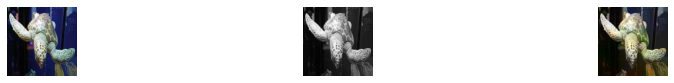

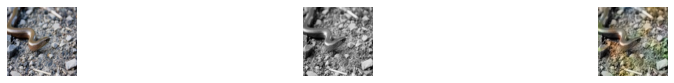

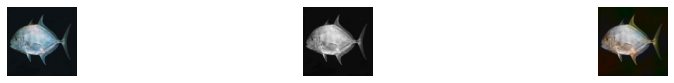

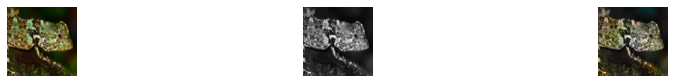

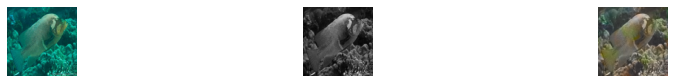

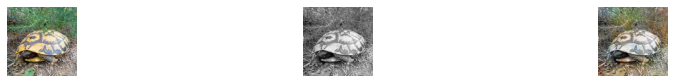

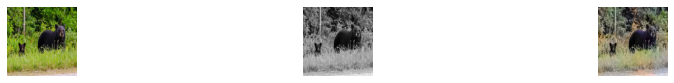

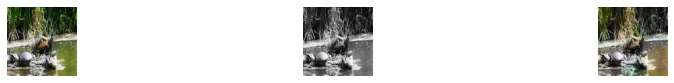

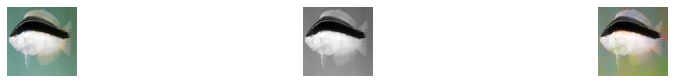

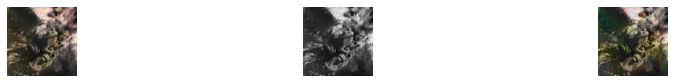

In [ ]:
compare_images(10, Data)

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


['unlabeleddata/trainData/2353.jpg', 'unlabeleddata/trainData/7448.jpg', 'unlabeleddata/trainData/1497.jpg', 'unlabeleddata/trainData/1741.jpg', 'unlabeleddata/trainData/3734.jpg', 'unlabeleddata/trainData/667.jpg', 'unlabeleddata/trainData/5300.jpg', 'unlabeleddata/trainData/5570.jpg', 'unlabeleddata/trainData/5395.jpg', 'unlabeleddata/trainData/4008.jpg']


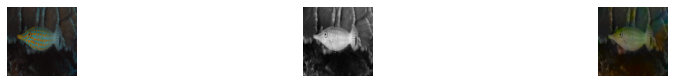

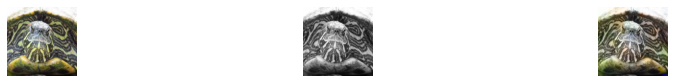

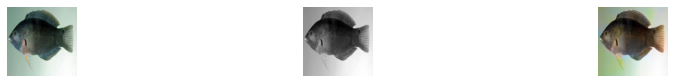

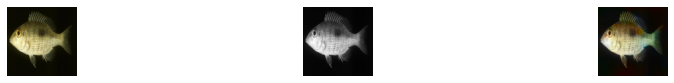

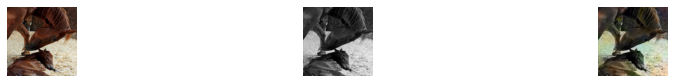

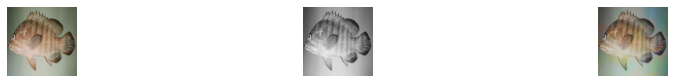

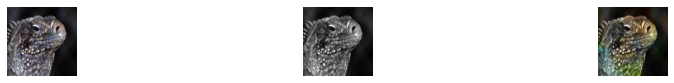

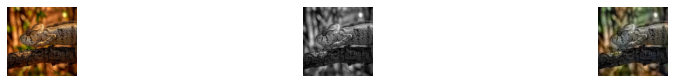

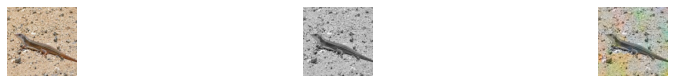

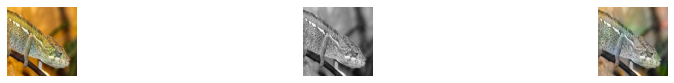

In [ ]:
compare_images(10, Data)

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 212 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


['unlabeleddata/trainData/7348.jpg', 'unlabeleddata/trainData/927.jpg', 'unlabeleddata/trainData/5531.jpg', 'unlabeleddata/trainData/820.jpg', 'unlabeleddata/trainData/7541.jpg', 'unlabeleddata/trainData/3799.jpg', 'unlabeleddata/trainData/2497.jpg', 'unlabeleddata/trainData/3388.jpg', 'unlabeleddata/trainData/1255.jpg', 'unlabeleddata/trainData/2387.jpg']


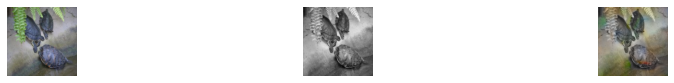

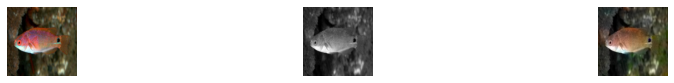

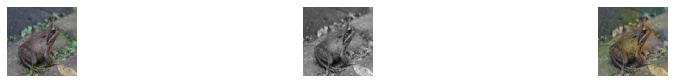

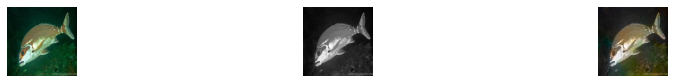

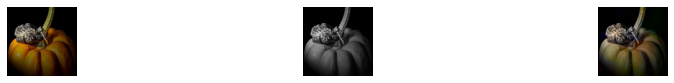

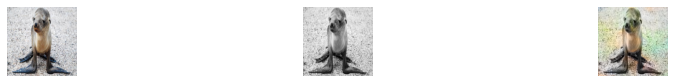

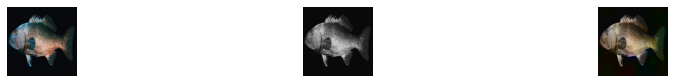

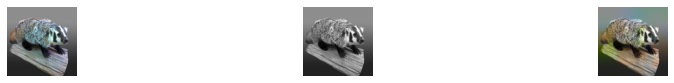

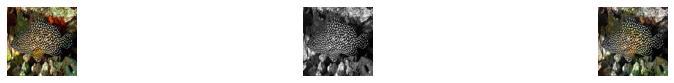

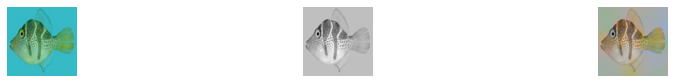

In [ ]:
compare_images(10, Data)

In [ ]:
import random
random.sample(range(3),2)

[2, 0]